[View in Colaboratory](https://colab.research.google.com/github/kentaojapi/dataanalysis_tgs-salt/blob/master/20181012_11_kaggle_salt.ipynb)

In [27]:
# download API key from google drive
## Original: https://colab.research.google.com/drive/1eufc8aNCdjHbrBhuy7M7X6BGyzAyRbrF#scrollTo=y5_288BYp6H1
## When you run for the first time, you will see a link to authenticate.

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


Download 100%.


In [28]:
!ls

20th-25epochs-model1-tgs-salt-20181013081000.h5  sample_data
adc.json					 sample_submission.csv
depths.csv					 test
drive						 train
masks						 train.csv


In [0]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c tgs-salt-identification-challenge
!unzip train.zip
!mv images/ train/
!unzip test.zip
!mv images/ test/
!rm train.zip
!rm test.zip
!df -h
from IPython.display import clear_output
clear_output()

In [0]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Add, multiply
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf


from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

In [0]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('../content/train/' + img_name + '.png')
    img_mask = load_img('../content/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [0]:
# version = 5
# basic_name = f'Unet_resnet_v{version}'
# save_model_name = basic_name + '.model'
# submission_file = basic_name + '.csv'

# print(save_model_name)
# print(submission_file)

In [0]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [31]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("../content/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../content/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [0]:
train_df["images"] = [np.array(load_img("../content/train/{}.png".format(idx), grayscale=True)) / 255 for idx in train_df.index]


In [0]:
train_df["masks"] = [np.array(load_img("../content/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in train_df.index]

In [0]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5,0,'Coverage class')

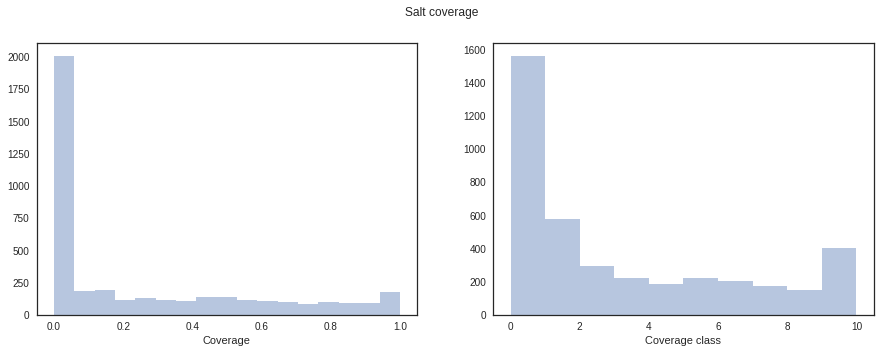

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5,1,'Depth distribution')

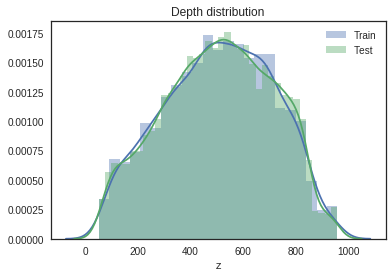

In [36]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [0]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [0]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
        #x = Dropout(0.5)(x) #add
    return x

# def se_block(x, filters):
#     x = AveragePooling2D(pool_size=(FIELD_SIZE, FIELD_SIZE))(x)
#     x = Conv2D(filters, (1, 1))(x)
#     x = Activation("relu")(x)
#     x = Conv2D(128, (1, 1))(x)
#     x = Activation("sigmoid")(x)
#     x = UpSampling2D(size=(FIELD_SIZE, FIELD_SIZE))(x)
#     x = 
#     return x
    
def se_block(input_tensor, compress_rate = 16):
    num_channels = int(input_tensor.shape[-1]) # Tensorflow backend
    bottle_neck = int(num_channels//compress_rate)
    se_branch = GlobalAveragePooling2D()(input_tensor)
    se_branch = Dense(bottle_neck, activation='relu')(se_branch)
    se_branch = Dense(num_channels, activation='sigmoid')(se_branch)
    x = input_tensor 
    out = multiply([x, se_branch])
    return out

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = se_block(x)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [0]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1, start_neurons * 1)
    conv1 = residual_block(conv1, start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)
    
    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)
                                  
    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)

    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
                                  
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [0]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [0]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        #loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [42]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


In [22]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16, 0.5)

model1 = Model(input_layer, output_layer)

#c = optimizers.adam(lr = 0.01)
c = optimizers.Nadam(lr=0.0005)
#c = optimizers.SGD(decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 101, 101, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 101, 101, 16) 64          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 101, 101, 16) 0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
conv2d_5 (

In [0]:
class ModelSave(ModelCheckpoint):
    def __init__(self, filepath, verbose=0, save_freq=25):
        super(ModelSave, self).__init__(filepath, verbose=verbose)
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.save_freq == 0:
            times = epoch / self.save_freq 
            model1.save("drive/My Drive/kaggle/{0}times-{1}".format(times, self.filepath))

In [24]:
#1st-25epochs
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
save_file = '20th-25epochs-model1-tgs-salt-{}.h5'.format(now)

from google.colab import drive
drive.mount('/content/drive')

early_stopping = EarlyStopping(monitor='my_iou_metric', mode='max', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_file, monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode='max', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
save_model =ModelSave(filepath=save_file)

epochs = 125
#epochs = 25
batch_size = 32

history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr, save_model], 
                    verbose=2)

model1.save("drive/My Drive/kaggle/{}".format(save_file))


Mounted at /content/drive
Train on 6400 samples, validate on 800 samples
Epoch 1/125
 - 127s - loss: 0.4276 - my_iou_metric: 0.3506 - val_loss: 0.3872 - val_my_iou_metric: 0.3754

Epoch 00001: my_iou_metric improved from -inf to 0.35056, saving model to 20th-25epochs-model1-tgs-salt-20181013081000.h5
Epoch 2/125
 - 109s - loss: 0.2820 - my_iou_metric: 0.5242 - val_loss: 0.3936 - val_my_iou_metric: 0.4601

Epoch 00002: my_iou_metric improved from 0.35056 to 0.52416, saving model to 20th-25epochs-model1-tgs-salt-20181013081000.h5
Epoch 3/125
 - 109s - loss: 0.2337 - my_iou_metric: 0.5745 - val_loss: 0.6924 - val_my_iou_metric: 0.5055

Epoch 00003: my_iou_metric improved from 0.52416 to 0.57450, saving model to 20th-25epochs-model1-tgs-salt-20181013081000.h5
Epoch 4/125
 - 109s - loss: 0.2153 - my_iou_metric: 0.6067 - val_loss: 0.2235 - val_my_iou_metric: 0.6159

Epoch 00004: my_iou_metric improved from 0.57450 to 0.60673, saving model to 20th-25epochs-model1-tgs-salt-20181013081000.h5
Ep

KeyboardInterrupt: ignored

In [44]:
#1st-25epochs
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
save_file = '5.0-20th-125epochs-model1-tgs-salt-{}.h5'.format(now)

from google.colab import drive
drive.mount('/content/drive')
file_name = '4.0times-20th-25epochs-model1-tgs-salt-20181013081000.h5'
model1 = load_model('drive/My Drive/kaggle/{}'.format(file_name),
                   custom_objects={'my_iou_metric': my_iou_metric})

early_stopping = EarlyStopping(monitor='my_iou_metric', mode='max', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_file, monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode='max', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

#epochs = 100
epochs = 50
batch_size = 32

history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

model1.save("drive/My Drive/kaggle/{}".format(save_file))

Mounted at /content/drive
Train on 6400 samples, validate on 800 samples
Epoch 1/50
 - 122s - loss: 0.0443 - my_iou_metric: 0.8349 - val_loss: 0.1547 - val_my_iou_metric: 0.7916

Epoch 00001: my_iou_metric improved from -inf to 0.83489, saving model to 5.0-20th-125epochs-model1-tgs-salt-20181013111010.h5
Epoch 2/50
 - 108s - loss: 0.0481 - my_iou_metric: 0.8290 - val_loss: 0.1794 - val_my_iou_metric: 0.7859

Epoch 00002: my_iou_metric did not improve from 0.83489
Epoch 3/50
 - 108s - loss: 0.0433 - my_iou_metric: 0.8357 - val_loss: 0.1529 - val_my_iou_metric: 0.7923

Epoch 00003: my_iou_metric improved from 0.83489 to 0.83573, saving model to 5.0-20th-125epochs-model1-tgs-salt-20181013111010.h5
Epoch 4/50
 - 108s - loss: 0.0472 - my_iou_metric: 0.8289 - val_loss: 0.1371 - val_my_iou_metric: 0.7829

Epoch 00004: my_iou_metric did not improve from 0.83573
Epoch 5/50
 - 108s - loss: 0.0469 - my_iou_metric: 0.8293 - val_loss: 0.1675 - val_my_iou_metric: 0.7821

Epoch 00005: my_iou_metric d

In [0]:
# 1st-50epochs
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
save_file = '19th-model1-50epochs-tgs-salt-{}.h5'.format(now)

from google.colab import drive
drive.mount('/content/drive')
file_name = '14th-50epochs-model1-tgs-salt-20181011031055.h5'
model1 = load_model('drive/My Drive/kaggle/{}'.format(file_name),
                   custom_objects={'my_iou_metric': my_iou_metric})

early_stopping = EarlyStopping(monitor='my_iou_metric', mode='max', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_file, monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode='max', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 25
#epochs = 200
batch_size = 32
history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

model1.save("drive/My Drive/kaggle/{}".format(save_file))

In [0]:
# 1st-75epochs
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
save_file = '15th-model1-75epochs-tgs-salt-{}.h5'.format(now)

from google.colab import drive
drive.mount('/content/drive')

early_stopping = EarlyStopping(monitor='my_iou_metric', mode='max', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_file, monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode='max', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 25
#epochs = 200
batch_size = 32

history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

model1.save("drive/My Drive/kaggle/{}".format(save_file))

In [0]:
# 1st-100epochs
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
save_file = '15th-model1-100epochs-tgs-salt-{}.h5'.format(now)

from google.colab import drive
drive.mount('/content/drive')

early_stopping = EarlyStopping(monitor='my_iou_metric', mode='max', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_file, monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode='max', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 25
#epochs = 200
batch_size = 32

history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

model1.save("drive/My Drive/kaggle/{}".format(save_file))

In [0]:
# 1st-125epochs
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
save_file = '13th-model1-125epochs-tgs-salt-{}.h5'.format(now)

from google.colab import drive
drive.mount('/content/drive')
file_name = '15th-model1-100epochs-tgs-salt-20181011071012.h5'
model1 = load_model('drive/My Drive/kaggle/{}'.format(file_name),
                   custom_objects={'my_iou_metric': my_iou_metric})


early_stopping = EarlyStopping(monitor='my_iou_metric', mode='max', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_file, monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode='max', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 25
#epochs = 200
batch_size = 32

history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

model1.save("drive/My Drive/kaggle/{}".format(save_file))

In [0]:
from google.colab import drive
drive.mount('/content/drive')
file_name = '20th-25epochs-model1-tgs-salt-20181012121058.h5'
model1 = load_model('drive/My Drive/kaggle/{}'.format(file_name),
                   custom_objects={'my_iou_metric': my_iou_metric})

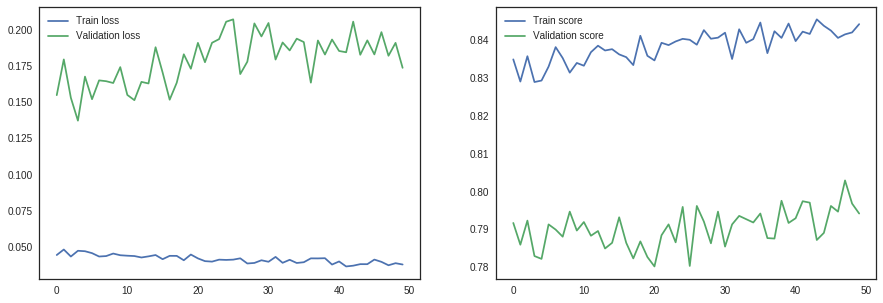

In [45]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()

In [68]:
# 2nd
from google.colab import drive
drive.mount('/content/drive')
file_name =  '3.0times-20th-25epochs-model1-tgs-salt-20181013081000.h5'

model1 = load_model('drive/My Drive/kaggle/{}'.format(file_name), custom_objects={'my_iou_metric': my_iou_metric})
# remove layter activation layer and use losvasz loss
input_x = model1.layers[0].input

output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
#c = optimizers.adam(lr = 0.01)
c = optimizers.Nadam(lr=0.002)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

model.summary()

Mounted at /content/drive
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 101, 101, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 101, 101, 16) 64          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 101, 101, 16) 0           batch_normalization_3[0][0]      
___________________________________________________________________________________

In [69]:
#2nd ~125epochs
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
save_file = '22th-model-tgs-salt-{}.h5'.format(now)

from google.colab import drive
drive.mount('/content/drive')

# early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max', patience=16, verbose=1)
model_checkpoint = ModelCheckpoint(save_file, monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)
save_model = ModelSave(filepath=save_file)

epochs = 50
batch_size = 32
#epochs = 100
#batch_size = 128

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr, save_model], 
                    verbose=2)

model.save("drive/My Drive/kaggle/{}".format(save_file))

Mounted at /content/drive
Train on 6400 samples, validate on 800 samples
Epoch 1/50
 - 240s - loss: 0.0909 - my_iou_metric_2: 0.7385 - val_loss: 0.2049 - val_my_iou_metric_2: 0.7329

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.73287, saving model to 22th-model-tgs-salt-20181013131016.h5
Epoch 2/50
 - 215s - loss: -1.3869e-02 - my_iou_metric_2: 0.7571 - val_loss: -3.8322e-02 - val_my_iou_metric_2: 0.7766

Epoch 00002: val_my_iou_metric_2 improved from 0.73287 to 0.77662, saving model to 22th-model-tgs-salt-20181013131016.h5
Epoch 3/50
 - 215s - loss: -1.7342e-02 - my_iou_metric_2: 0.7547 - val_loss: 0.1628 - val_my_iou_metric_2: 0.7229

Epoch 00003: val_my_iou_metric_2 did not improve from 0.77662
Epoch 4/50
 - 215s - loss: -5.2122e-02 - my_iou_metric_2: 0.7626 - val_loss: 0.1555 - val_my_iou_metric_2: 0.7249

Epoch 00004: val_my_iou_metric_2 did not improve from 0.77662
Epoch 5/50
 - 215s - loss: -8.7098e-02 - my_iou_metric_2: 0.7713 - val_loss: -2.3621e-02 - val_my_iou_me

In [0]:
#2nd 50epochs
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
save_file = '13th-model-50epochs-tgs-salt-Nadam-{}.h5'.format(now)

from google.colab import drive
drive.mount('/content/drive')
file_name = '13th-model-25epochs-tgs-salt-Nadam-20181010131009.h5'
model = load_model('drive/My Drive/kaggle/{}'.format(file_name),
                   custom_objects={'my_iou_metric_2': my_iou_metric_2, 'lovasz_loss': lovasz_loss})

# early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max', patience=16, verbose=1)
model_checkpoint = ModelCheckpoint(save_file, monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)

epochs = 25
batch_size = 32
#epochs = 100
#batch_size = 128

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

model.save("drive/My Drive/kaggle/{}".format(save_file))

In [0]:
#2nd 75epochs
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
save_file = '13th-model-75-epochs-tgs-salt_{}.h5'.format(now)

from google.colab import drive
drive.mount('/content/drive')
file_name = '13th-model-50epochs-tgs-salt-Nadam-20181010211028.h5'
model = load_model('drive/My Drive/kaggle/{}'.format(file_name),
                   custom_objects={'my_iou_metric_2': my_iou_metric_2, 'lovasz_loss': lovasz_loss})

# early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max', patience=16, verbose=1)
model_checkpoint = ModelCheckpoint(save_file, monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max', factor=0.5, patience=8, min_lr=0.0001, verbose=1)

epochs = 25
batch_size = 32
#epochs = 100
#batch_size = 128

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

model.save("drive/My Drive/kaggle/{}".format(save_file))

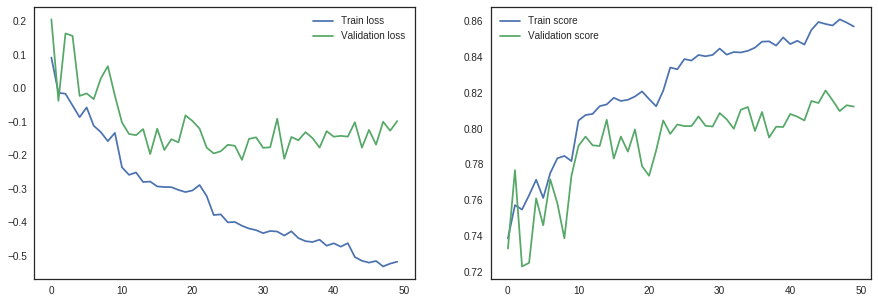

In [70]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [0]:
from google.colab import drive
drive.mount('/content/drive')
model = load_model('drive/My Drive/kaggle/7-model-tgs-salt-Nadam-20181008141024.h5', custom_objects={'my_iou_metric_2': my_iou_metric_2, 'lovasz_loss': lovasz_loss})

In [0]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [0]:
#preds_valid = predict_result(model1, x_valid, img_size_target)
preds_valid = predict_result(model, x_valid, img_size_target)

In [0]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
    #temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [74]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in thresholds])
print(ious)

[0.805375 0.805625 0.806125 0.807125 0.80725  0.809    0.81     0.809875
 0.81175  0.8125   0.81275  0.8145   0.816125 0.817    0.81725  0.81875
 0.819375 0.819625 0.8195   0.819625 0.818875 0.818875 0.82     0.82
 0.824125 0.824375 0.823875 0.82375  0.822625 0.822625 0.82225 ]


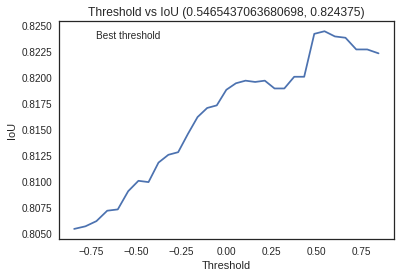

In [75]:
# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [0]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:
x_test = np.array([(np.array(load_img("../content/test/{}.png".format(idx), grayscale = True))) / 255 for idx in test_df.index]).reshape(-1, img_size_target, img_size_target, 1)

In [0]:
#preds_test = predict_result(model1, x_test,img_size_target)
preds_test = predict_result(model, x_test,img_size_target)

In [59]:
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(test_df.index.values)}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

Usedtime = 6.557890892028809 s


In [0]:
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
#submit_name = '20th-model1-tgs-salt-submission_{}.csv'.format(now)
submit_name = '23th-model-tgs-salt-submission_{}.csv'.format(now)


sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submit_name)

In [64]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")

Kernel run time = 1.6770763774050608 hours


In [65]:
!cp "../content/$submit_name" "drive/My Drive/kaggle/"
!kaggle competitions submit -c tgs-salt-identification-challenge -f "drive/My Drive/kaggle/$submit_name" -m "$now"


Successfully submitted to TGS Salt Identification Challenge